# Start Session

In [1]:
# this has to be run on the cluster version 
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1622216935872_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import types as t
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime as dt
from pyspark.sql import types as T
import pandas as pd
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load Data
Here the entire set of 26 million rows is loaded. 

In [4]:
# full dataset
event_data = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'
# mini dataset
# event_data = s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json
# udacity workspace
# event_data = "mini_sparkify_event_data.json"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df = spark.read.json(event_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+---------+------+-------------+--------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|              artist|     auth|firstName|gender|itemInSession|lastName|    length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+--------------------+---------+---------+------+-------------+--------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|           Popol Vuh|Logged In|    Shlok|     M|          278| Johnson| 524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|         Los Bunkers|Logged In|  Vianney|     F|            9|  Miller| 238.39302| paid|San Francisco-Oak...|  

In [7]:
# the size of the dataset
print((df.count(), len(df.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(26259199, 18)

### How Many Nulls? 

In [10]:
# show percent nulls
# because 'artist','length','song' have so many missing values I will not use them
df.select(
    [
        ( (F.count(F.when(F.isnull(c), c)) / F.count(c)) * 100 ) \
            .alias(c) for c in df.columns
    ]
).show(vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0--------------------------
 artist        | 25.94175749841537 
 auth          | 0.0               
 firstName     | 3.055168770741172 
 gender        | 3.055168770741172 
 itemInSession | 0.0               
 lastName      | 3.055168770741172 
 length        | 25.94175749841537 
 level         | 0.0               
 location      | 3.055168770741172 
 method        | 0.0               
 page          | 0.0               
 registration  | 3.055168770741172 
 sessionId     | 0.0               
 song          | 25.94175749841537 
 status        | 0.0               
 ts            | 0.0               
 userAgent     | 3.055168770741172 
 userId        | 0.0

### Define Churn
`Churn` is defined as when the app registers the `Cancellation Confirmation` page. This occurs for both free and paid users. 

In [11]:
# this is a binary, indicator column to be used to predict churn
df = df.withColumn(
    'churn',
    F.when((F.col('page') =='Cancellation Confirmation'), 1) \
    .otherwise(0)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Data Exploration

In [12]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)

In [13]:
# create udf
get_month = F.udf(lambda month: dt.fromtimestamp( month / 1000.0 ).strftime("%m") if month is not None else None)
# 
df = df.withColumn("registrationMonth", get_month("registration").cast(T.IntegerType())) \
    .withColumn("tsMonth", get_month("ts").cast(T.IntegerType())) \
    .withColumn("diffMonth", F.col("tsMonth") - F.col("registrationMonth"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
cancel_rate_by_month = df.select("diffMonth","churn", "userId") \
    .filter(df.diffMonth > 0) \
    .filter(df.diffMonth < 6) \
    .dropDuplicates() \
    .groupBy("diffMonth") \
    .pivot("churn") \
    .agg(F.countDistinct("userId").alias("userIdCount")) \
    .orderBy("diffMonth") \
    .withColumn("percent", ( F.col("1") / ( F.col("1") + F.col("0") ) ) * 100 ) \
    .select("diffMonth", "percent") \
    .toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

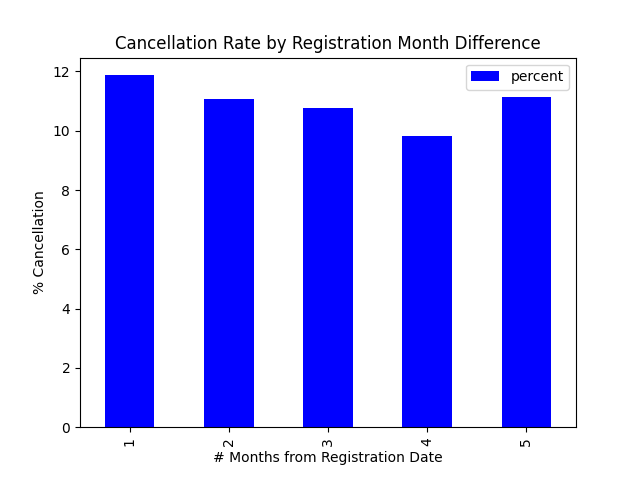

In [17]:
cancel_rate_by_month.plot(kind='bar',x='diffMonth',y='percent', color='blue')
plt.title('Cancellation Rate by Registration Month Difference')
plt.xlabel('# Months from Registration Date')
plt.ylabel('% Cancellation')
%matplot plt

In [18]:
# users who have a cancellation value of 1
users_who_quit = df.filter(df.churn==1) \
    .select(df.userId) \
    .dropDuplicates()

# users who have a cancellation value of 0
users_who_stayed = df.filter(df.churn==0) \
    .select(df.userId) \
    .dropDuplicates()

# examine their lengths
users_who_quit.count(), users_who_stayed.count(), ( users_who_quit.count() / (users_who_quit.count() + users_who_stayed.count())) * 100

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(5003, 22278, 18.338770572926215)

In [19]:
# are cancellation rates the same between free and paid users? 
churn_table = df.select("level","churn","userId") \
    .dropDuplicates() \
    .groupBy("level") \
    .pivot("churn") \
    .agg(F.count("userId").alias("userIdCount")) \
    .withColumn("percent", (F.col("1")/(F.col("1") + F.col("0")))*100) \
    .toPandas() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

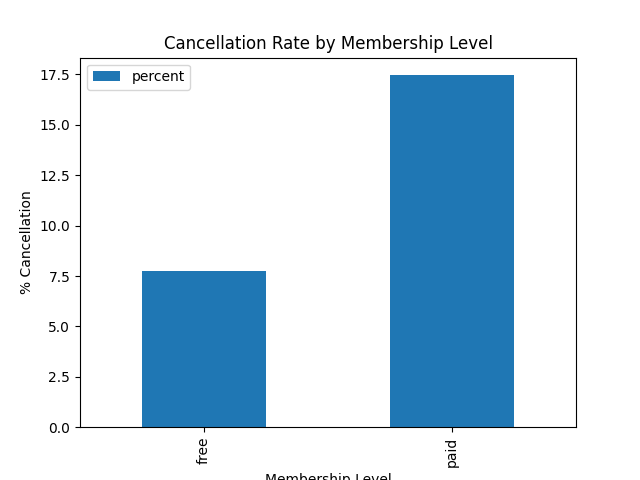

In [20]:
churn_table.plot(kind='bar',x='level',y='percent')
plt.title('Cancellation Rate by Membership Level')
plt.xlabel('Membership Level')
plt.ylabel('% Cancellation')
%matplot plt

In [21]:
# are cancellation rates the same between genders? 
churn_table = df.select("gender","churn","userId") \
    .filter(~F.isnull("gender")) \
    .dropDuplicates() \
    .groupBy("gender") \
    .pivot("churn") \
    .agg(F.count("userId").alias("userIdCount")) \
    .withColumn("percent", (F.col("1")/(F.col("1") + F.col("0"))) * 100) \
    .toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

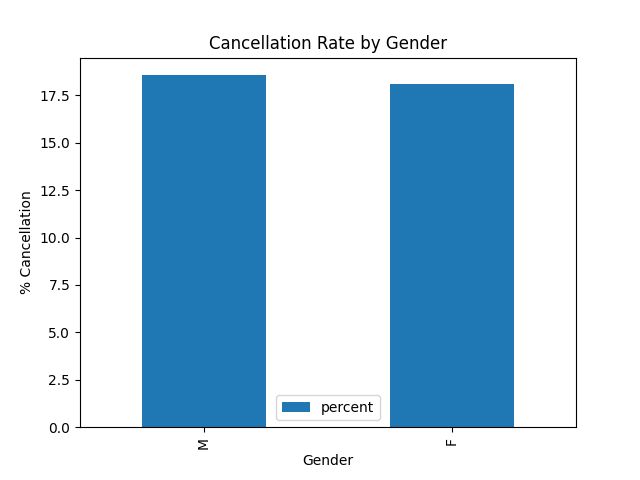

In [22]:
churn_table.plot(kind='bar',x='gender',y='percent')
plt.title('Cancellation Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('% Cancellation')
%matplot plt

# Feature Engineering
The goal is to predict behavior at the user level--specifically if the user 'churns' or not. Therefore, my feature engineering focuses on finding characteristics at the `user` level. For each feature, I create a dataframe with the `userId` as the key. The dataframes are joined together, ensuring that one row eqauls one unique `userId`. Finally, the `userId` column is dropped. 

Ideas for features are: 
1. Cumulative Totals Per User: 
    - Add Friends
    - Add to Playlist
    - Roll Advertisement
    - Error
    - Login / Logout
    - Thumbs Up / Thumbs Down
    - Submit Upgrade / Submit Downgrade

2. Location: 
    - City
    - State
    
3. userAgent: 
    - browser
    - os 
    - brand
    
4. Time: 
    - Avg. Length of Session
    - Time Spent as Free / Paid Level
    - Time User spent on Sparkify
    
5. Gender of User / Registration Month

### 1. Cumulative Totals DataFrame

In [23]:
# Cumulative Totals of Page Per User
page_list = ["Add Friend", "Add to Playlist", "Logout", "Thumbs Up", 
             "Thumbs Down", "Error", "Roll Advert", "Help"]

user_page = df.select("userId","page") \
    .filter(F.col("page").isin(page_list)) \
    .groupBy("userId") \
    .pivot("page") \
    .agg(F.count("page").alias("page_count"))

user_page.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+---------------+-----+----+------+-----------+-----------+---------+
| userId|Add Friend|Add to Playlist|Error|Help|Logout|Roll Advert|Thumbs Down|Thumbs Up|
+-------+----------+---------------+-----+----+------+-----------+-----------+---------+
|1492713|         9|             20| null|   5|    13|         36|          3|       23|
|1396135|        13|             21| null|   9|     8|          1|          9|       49|
|1676292|        46|             44| null|   7|    21|          6|         17|       81|
|1690101|        29|             71|    3|  14|    29|          6|         17|      217|
|1076191|      null|              1| null|null|     1|          5|          1|        4|
|1927371|         2|              9| null|   2|     3|          8|          5|       32|
|1010669|        77|             69|    2|  14|    21|          5|         23|      139|
|1976623|         2|              6| null|   3|     1|         15|          3|       11|
|1110773|        10| 

### 2. Location DataFrame

In [24]:
# split the 'location' field into 'city' and 'state fields'
user_location = df.withColumn('city', F.split(df['location'], ',').getItem(0)) \
    .withColumn('state', F.split(df['location'], ',').getItem(1)) \
    .select("userId","city","state") \
    .dropDuplicates()

user_location.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+---------+
| userId|                city|    state|
+-------+--------------------+---------+
|1952240|              Wilson|       NC|
|1268300|San Antonio-New B...|       TX|
|1466490|Seattle-Tacoma-Be...|       WA|
|1613995|          Cincinnati| OH-KY-IN|
|1585384|Seattle-Tacoma-Be...|       WA|
|1717762|North Port-Saraso...|       FL|
|1918902|Miami-Fort Lauder...|       FL|
|1608368|Seattle-Tacoma-Be...|       WA|
|1626875|  Vineland-Bridgeton|       NJ|
|1743156|               Kapaa|       HI|
|1303002|        Williamsport|       PA|
|1571170|Boston-Cambridge-...|    MA-NH|
|1267740|         Tallahassee|       FL|
|1612851|             El Paso|       TX|
|1336976|Gulfport-Biloxi-P...|       MS|
|1230631|       Coeur d'Alene|       ID|
|1882847| Niles-Benton Harbor|       MI|
|1072073|Detroit-Warren-De...|       MI|
|1893294|New York-Newark-J...| NY-NJ-PA|
|1161627|New Orleans-Metairie|       LA|
+-------+--------------------+---------+
only showing top

### 3. Browser/Device DataFrame

In [25]:
# create browser, os, brand from userAgent
df = df.withColumn('browser', F.split(df['userAgent'], '\(').getItem(0)) \
    .withColumn('temp', F.split(df['userAgent'], '\(').getItem(1)) 

df = df.withColumn('os', F.split(df['temp'], ';').getItem(0)) \
    .withColumn('brand', F.split(df['temp'], ';').getItem(1))

user_browser = df.select("userId","browser","os","brand").dropDuplicates()

user_browser.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+--------------------+--------------------+
| userId|      browser|                  os|               brand|
+-------+-------------+--------------------+--------------------+
|1767318|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|1746631|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|1490241|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|1869069|"Mozilla/5.0 |      Windows NT 6.1| WOW64) AppleWebK...|
|1697168| Mozilla/5.0 |           Macintosh| Intel Mac OS X 10.9|
|1115082|"Mozilla/5.0 |      Windows NT 6.1| WOW64) AppleWebK...|
|1411971|"Mozilla/5.0 |      Windows NT 6.3| WOW64) AppleWebK...|
|1930998| Mozilla/5.0 |          compatible|           MSIE 10.0|
|1791856|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|1869054|"Mozilla/5.0 |              iPhone| CPU iPhone OS 7_...|
|1171472|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|1572943|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|1391043|"

### 4. Time DataFrames

In [26]:
# create window partition
w = Window.partitionBy("userId","sessionId").orderBy("sessionId")
# calculate session duration ( per user ) in HOURS
user_sess_dur = df.select("userId","sessionId","ts") \
    .withColumn("max_ts", F.max('ts').over(w)) \
    .withColumn("min_ts", F.min('ts').over(w)) \
    .withColumn("tsDiff", ( F.col('max_ts') - F.col('min_ts')) / ( 1000 * 3600 )) \
    .select("userId","sessionId","tsDiff") \
    .dropDuplicates() \
    .groupBy("userId") \
    .agg(F.round(F.avg("tsDiff"),1).alias("avgSessionHours"))

user_sess_dur.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+
| userId|avgSessionHours|
+-------+---------------+
|1114507|            4.4|
|1142513|            3.3|
|1180406|            4.3|
|1271218|            6.9|
|1338783|            7.9|
|1349958|            5.3|
|1380035|            5.5|
|1396135|            7.6|
|1440693|            1.4|
|1624220|            1.8|
|1690101|            4.4|
|1699838|            3.4|
|1880560|            6.7|
|1001393|            5.2|
|1025974|            4.2|
|1216358|            2.1|
|1297189|            3.6|
|1766909|            2.1|
|1883991|            7.6|
|1972195|            6.0|
+-------+---------------+
only showing top 20 rows

In [27]:
# create window partition
w = Window.partitionBy("userId").orderBy("userId")
# calculate total time used
user_days = df.select("userId","ts") \
    .withColumn("max_ts", F.max('ts').over(w)) \
    .withColumn("min_ts", F.min('ts').over(w)) \
    .withColumn("daysUsed", F.round(( F.col('max_ts') - F.col('min_ts') ) / ( 1000 * 3600 * 24), 1)) \
    .select("userId", "daysUsed") \
    .dropDuplicates()

user_days.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------+
| userId|daysUsed|
+-------+--------+
|1001393|    58.6|
|1002143|    57.2|
|1002493|     8.4|
|1002749|    55.9|
|1004060|    48.0|
|1004316|    53.2|
|1006033|    45.2|
|1006411|    59.5|
|1006697|    50.9|
|1008110|    38.1|
|1008244|     3.3|
|1008404|    39.0|
|1010669|    60.0|
|1010907|    49.2|
|1011093|    57.7|
|1011149|    50.2|
|1011630|    31.3|
|1012906|    10.0|
|1013788|    37.6|
|1016331|    23.5|
+-------+--------+
only showing top 20 rows

In [28]:
# create window partition
w = Window.partitionBy("userId", "level").orderBy("userId")

user_level = df.select("userId", "level", "ts") \
    .withColumn("max_ts", F.max("ts").over(w)) \
    .withColumn("min_ts", F.min("ts").over(w)) \
    .withColumn("daysAs", (F.col("max_ts") - F.col("min_ts")) / (1000 * 3600 * 24)) \
    .select("userId","level","daysAs") \
    .dropDuplicates() \
    .groupBy("userId") \
    .pivot("level") \
    .agg(F.round(F.avg("daysAs"),1))

user_level.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+----+
| userId|free|paid|
+-------+----+----+
|1076191| 7.9|null|
|1114507|15.8|43.9|
|1271218|44.2|53.4|
|1695825| 0.0|null|
|1216358|32.9|10.3|
|1337238|56.1|null|
|1823263|33.8|null|
|1553256| 5.5|31.1|
|1754369|36.5| 9.0|
|1844759| 0.0|56.6|
|1857514|46.0|11.5|
|1416126|24.9|33.1|
|1877212| 0.2|60.0|
|1303829|39.1|null|
|1460896|56.3|32.9|
|1558241|52.6| 5.7|
|1616882|12.5| 4.6|
|1269506| 0.0| 0.3|
|1479463| 5.5|41.8|
|1011093|57.7|29.7|
+-------+----+----+
only showing top 20 rows

### 5. Gender and Registration Month DataFrame

In [29]:
user_gender = df.select("userId", "gender","registrationMonth") \
    .dropDuplicates()

user_gender.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+-----------------+
| userId|gender|registrationMonth|
+-------+------+-----------------+
|1676531|     F|                7|
|1416906|     M|                9|
|1997379|     M|                9|
|1649859|     M|                8|
|1201265|     M|                8|
|1844374|     F|                9|
|1795089|     M|                9|
|1065146|     M|                9|
|1374533|     M|                6|
|1222662|     F|                9|
|1458761|     M|                9|
|1095073|     F|                7|
|1879941|     F|                9|
|1347570|     F|                9|
|1526362|     M|                9|
|1173098|     F|                8|
|1219526|     F|                9|
|1745257|     M|                9|
|1669439|     F|                9|
|1341784|     M|                6|
+-------+------+-----------------+
only showing top 20 rows

### 6. Churn DataFrame

In [30]:
# create churn table
user_churn = df.select("userId", "churn") \
    .groupBy("userId") \
    .agg(F.sum("churn").alias("label"))

user_churn.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
| userId|label|
+-------+-----+
|1271218|    0|
|1567623|    0|
|1676292|    0|
|1242455|    0|
|1927014|    0|
|1972195|    0|
|1766909|    0|
|1216358|    1|
|1976623|    0|
|1008404|    1|
|1532612|    0|
|1816366|    0|
|1193157|    0|
|1114602|    0|
|1460523|    0|
|1205653|    1|
|1670523|    0|
|1844759|    0|
|1652508|    0|
|1931889|    1|
+-------+-----+
only showing top 20 rows

### Join DataFrames

In [31]:
# 'user_location' and 'user_days' are not used. 
# 'user_location' does not describe user behavior
# 'user_days' is the sum of 'free' and 'paid' in 'user_level' so could be a confounder
# join all the tables together
user_data = user_churn.join(user_page, ['userId'], "left") \
    .join(user_browser,['userId'], "left") \
    .join(user_sess_dur, ['userId'], "left") \
    .join(user_level, ['userId'], "left") \
    .join(user_gender, ['userId'], "left") \
    .drop("userId")

user_data.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0---------------------------------
 label             | 0                    
 Add Friend        | 11                   
 Add to Playlist   | 18                   
 Error             | 1                    
 Help              | 6                    
 Logout            | 11                   
 Roll Advert       | null                 
 Thumbs Down       | 6                    
 Thumbs Up         | 43                   
 browser           | "Mozilla/5.0         
 os                | Windows NT 5.1) A... 
 brand             | null                 
 avgSessionHours   | 5.2                  
 free              | 0.1                  
 paid              | 58.5                 
 gender            | M                    
 registrationMonth | 9                    
only showing top 1 row

In [32]:
# final size of dataset
print((user_data.count(), len(user_data.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(22278, 17)

### Replace Nulls

In [33]:
# define list of numeric columns
numeric_cols = user_page.columns[1:] + user_sess_dur.columns[1:] + user_level.columns[1:] + ['registrationMonth']
# create dictionary specifying that 0 will be used to fill missing rows
impute_numeric = { i : 0 for i in numeric_cols }
# fill missing rows in numeric columns
user_data = user_data.fillna(impute_numeric)
# define list of category columns (strings)
categ_cols = user_browser.columns[1:] + ['gender']
# create dictionary specifying that 'missing' will be used to fill missing rows
impute_categ = { i : 'missing' for i in categ_cols }
# fill missing rows in category columns
user_data = user_data.fillna(impute_categ)
# show % nulls - should be 0 for every column
user_data.select(
    [
        ( (F.count(F.when(F.isnull(c), c)) / F.count(c)) * 100 ) \
            .alias(c) for c in user_data.columns
    ]
).show(vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------
 label             | 0.0 
 Add Friend        | 0.0 
 Add to Playlist   | 0.0 
 Error             | 0.0 
 Help              | 0.0 
 Logout            | 0.0 
 Roll Advert       | 0.0 
 Thumbs Down       | 0.0 
 Thumbs Up         | 0.0 
 browser           | 0.0 
 os                | 0.0 
 brand             | 0.0 
 avgSessionHours   | 0.0 
 free              | 0.0 
 paid              | 0.0 
 gender            | 0.0 
 registrationMonth | 0.0

# Modeling

### Split into Training / Testing Sets

In [34]:
training, testing = user_data.randomSplit([0.6, 0.4], seed=100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Create Pipeline

In [35]:
# create list of category output columns from previously defined categ_columns
o_categ_cols = [ n + 'Index' for n in categ_cols ] 
# encode categories in pipeline
categ_pipeline = Pipeline(stages=[
    StringIndexer(inputCols=categ_cols, outputCols=o_categ_cols, handleInvalid='skip'),
    VectorAssembler(
        inputCols=o_categ_cols, 
        outputCol="categ_features"
    )
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
# numeric pipeline - use numeric columns defined earlier
numer_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=numeric_cols, outputCol="numer_features")
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# unite pipelines ( final features have to be named 'features')
# unite pipelines
final_pipeline = Pipeline(stages=[
    categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        inputCols=["categ_features","numer_features"],
        outputCol="features"
    ),
    LogisticRegression(maxIter=10)
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Cross-Validate on Training Set

In [38]:
# define parameters ( just one )
paramGrid = ParamGridBuilder() \
    .addGrid(LogisticRegression.regParam, [0.1, 0.05, 0.01]) \
    .build()

# optimize 4 fold cross-validation using the area under ROC curve
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC'),
                          numFolds=3) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
cvModel = crossval.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-39:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2023



In [40]:
# certainly looks like the regParam is fine at 0.1
cvModel.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.8386717889683337, 0.8386717889683337, 0.8386717889683337]

### Fit Tuned Pipeline on Entire Training Set

In [48]:
# unite pipelines ( final features have to be named 'features')
final_pipeline2 = Pipeline(stages=[
    categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        inputCols=["categ_features","numer_features"],
        outputCol="features"
    ),
    LogisticRegression(maxIter=10, regParam=0.1)
])

pipelineModel = final_pipeline2.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# show accuracy and AUC
summaryPipeline = pipelineModel.stages[-1].summary
summaryPipeline.accuracy, summaryPipeline.areaUnderROC

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7829538645895746, 0.8369561600020986)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

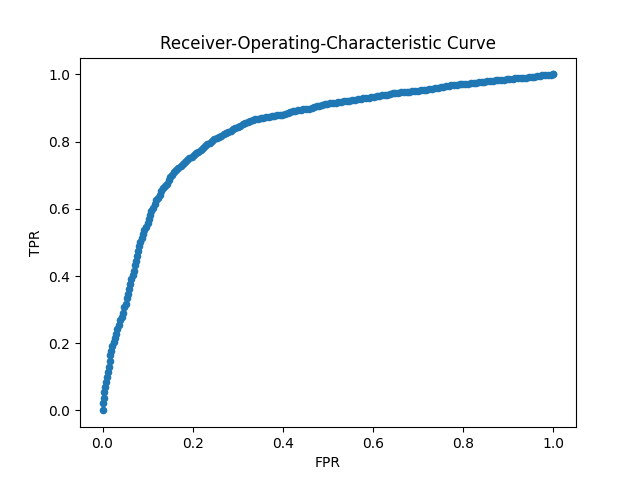

In [82]:
roc_pd = pipelineModel.stages[-1].summary.roc.toPandas()
roc_pd.plot(kind="scatter",x="FPR",y="TPR")
plt.title("Receiver-Operating-Characteristic Curve")
%matplot plt

### Calculate Odds-Ratios

In [50]:
import numpy as np

coeffs = pipelineModel.stages[-1].coefficientMatrix
odds_ratios = np.around(np.exp(coeffs.toArray()),2).tolist()
feature_list = o_categ_cols + numeric_cols
odds_ratios_df = spark.createDataFrame(
    [ t for t in zip(odds_ratios[0], feature_list)],
    ["or", "feature"]
)

odds_ratios_df.show(30)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----------------+
|  or|          feature|
+----+-----------------+
|1.02|     browserIndex|
| 1.0|          osIndex|
| 1.0|       brandIndex|
|1.03|      genderIndex|
| 1.0|       Add Friend|
| 1.0|  Add to Playlist|
| 1.0|            Error|
| 1.0|             Help|
| 1.0|           Logout|
|1.01|      Roll Advert|
|1.01|      Thumbs Down|
| 1.0|        Thumbs Up|
|1.01|  avgSessionHours|
|0.97|             free|
|0.98|             paid|
|1.05|registrationMonth|
+----+-----------------+

### Score on Testing Set

In [51]:
# generate predictions
predictions = pipelineModel.transform(testing)
# intialize the evaluator
bce = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC').evaluate(predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
# area-under-receiver-operating-characteristic-curve of testing set
bce

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.8436909134382706

# Results and Conclusion

Splitting the user data into training and testing sets (60% and 40%, respectively) was sufficient. The final AUC was: 
* 0.837 for the training set 
* 0.847 for the testing set

which is close enough together to suggest that under-fitting, and not over-fitting, was a possible issue. 

The odds-ratios showed that some features ( regarding user behavior ) were associated with an increased probability of 'churn' while others were associated with a _decreased_ probability of churn. Specifically: 

A _one_ unit increase of: 
* the number of advertisements
* the number of 'thumbs down' 
* the average number of hours a session lasted

_increased_ the probability of 'churning' by 1%

whereas a _one_ unit increase of: 
* browserIndex increased the probability of 'churning' by 2%
* genderIndex increased the probability of 'churning' by 3%
* registrationMonth increased the probability of 'churning' by 5%

Finally, a _one_ unit increase of: 
* days spent at the 'free' level _decreased_ the probability of 'churning' by 3%
* days spent at the 'paid' level _decreased_ the probability of 'churning' by 2%

The recommendation based on these findings is that Sparkify should investigate ways to: 
* limit the number of advertisements served to a user
* find ways to keep users engaged by the service over the long-term

Furthermore, Sparkify should investigate: 
* which songs / albums / artists associated with the greatest number of 'thumbs down' ratings
* which specific browser is associated with the most cancellations
* determine if there truly is a gender difference in cancellation rate